# Fine-Tuning T5 for Summarization
## Introduction
In this notebook, we fine-tune the T5 model on a summarization dataset.

### **Objectives:**
- Load and preprocess a dataset for text summarization.
- Train T5 on custom data to improve its summarization capabilities.
- Evaluate performance before and after fine-tuning.

Fine-tuning helps T5 generate more relevant and concise summaries based on domain-specific data.


## Step 1: Loading the CNN/DailyMail Dataset
We will use the **CNN/DailyMail dataset**, a widely used dataset for summarization tasks.

- Each sample contains:
  - `"article"` → The full news article.
  - `"highlights"` → The human-written summary.
- We will load only a **small subset** for efficient fine-tuning.

Dataset source: [Hugging Face Datasets](https://huggingface.co/datasets/cnn_dailymail)


In [32]:
!pip install datasets


^C


In [ ]:
from datasets import load_dataset
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
# Load CNN/DailyMail dataset (small subset)
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1%]")  # Load 1% of training data

# Print sample data
print(dataset[0])


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [ ]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print Model Info
print(f"Model '{model_name}' loaded successfully.")
print(f"Running on: {device}")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Model 't5-small' loaded successfully.
Running on: cpu


In [ ]:
def preprocess_function(sample):
    input_text = "summarize: " + sample["article"]
    target_summary = sample["highlights"]

    input_tokens = tokenizer(
        input_text, max_length = 512, truncation = True, 
        padding = "max_length")
    target_tokens = tokenizer(
        target_summary, max_length = 200, truncation = True, 
        padding = "max_length")

    model_inputs = dict(input_tokens)
    model_inputs["labels"] = target_tokens["input_ids"]

    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

print(tokenized_dataset[0])

Map:   0%|          | 0/2871 [00:00<?, ? examples/s]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

## Step 4: Convert to PyTorch Format and Create DataLoaders
Now that we've tokenized the dataset, we prepare it for training by:
- Converting it into PyTorch `Dataset` objects.
- Creating `DataLoader`s for batching during training and evaluation.


In [ ]:
tokenized_dataset.set_format(
    type="torch", 
    columns=["input_ids", "attention_mask", "labels"]
)

### Step 4.2 – Create DataLoaders
We use PyTorch's `DataLoader` to batch our dataset and prepare it for training. 
We also shuffle the training data to ensure better generalization.


In [ ]:
from torch.utils.data import DataLoader

In [38]:
# Reduce the dataset for faster testing
small_dataset = tokenized_dataset.select(range(100))

train_dataloader = DataLoader(small_dataset, batch_size=8, shuffle=True)

### Step 4.3 – Peek Inside One Batch
We’ll inspect a single batch to understand its structure: tensors for `input_ids`, `attention_mask`, and `labels`, all grouped into a dictionary.


In [39]:
# Get one batch from the training DataLoader
batch = next(iter(train_dataloader))

# Print keys and tensor shapes
for key in batch:
    print(f"{key}: shape = {batch[key].shape}")


input_ids: shape = torch.Size([8, 512])
attention_mask: shape = torch.Size([8, 512])
labels: shape = torch.Size([8, 200])


### Step 5 – Model Setup
We load the `T5-small` model using `T5ForConditionalGeneration`. During training, the model uses both `input_ids` and `labels` to calculate the loss and learn to summarize text.


In [40]:
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print Model Info
print(f"Model '{model_name}' loaded successfully.")
print(f"Running on: {device}")

Model 't5-small' loaded successfully.
Running on: cpu


### Step 6 – Training Loop
We create a simple training loop using PyTorch that:
- Loads batches from the DataLoader
- Sends inputs and labels to the model
- Calculates the loss
- Updates model weights using backpropagation


In [42]:
from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr = 5e-5)
num_epochs= 3
loss_values = []

model.train()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch +1}/{num_epochs}")
    for batch in tqdm(train_dataloader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels=labels)
        loss = outputs.loss
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(f"Loss: {loss.item():.4f}")




Epoch 1/3


  8%|▊         | 1/13 [00:03<00:36,  3.04s/it]

Loss: 2.3484


 15%|█▌        | 2/13 [00:05<00:32,  2.92s/it]

Loss: 1.9999


 23%|██▎       | 3/13 [00:08<00:29,  2.92s/it]

Loss: 1.7107


 31%|███       | 4/13 [00:11<00:26,  2.93s/it]

Loss: 1.7403


 38%|███▊      | 5/13 [00:14<00:23,  2.90s/it]

Loss: 1.8488


 46%|████▌     | 6/13 [00:17<00:19,  2.83s/it]

Loss: 1.7073


 54%|█████▍    | 7/13 [00:19<00:16,  2.76s/it]

Loss: 1.5981


 62%|██████▏   | 8/13 [00:22<00:13,  2.72s/it]

Loss: 1.5455


 69%|██████▉   | 9/13 [00:25<00:10,  2.72s/it]

Loss: 1.4854


 77%|███████▋  | 10/13 [00:28<00:08,  2.73s/it]

Loss: 1.6091


 85%|████████▍ | 11/13 [00:30<00:05,  2.75s/it]

Loss: 1.3984


 92%|█████████▏| 12/13 [00:33<00:02,  2.78s/it]

Loss: 1.5320


100%|██████████| 13/13 [00:34<00:00,  2.68s/it]


Loss: 1.2990

Epoch 2/3


  8%|▊         | 1/13 [00:02<00:32,  2.73s/it]

Loss: 1.5382


 15%|█▌        | 2/13 [00:05<00:30,  2.75s/it]

Loss: 1.4241


 23%|██▎       | 3/13 [00:08<00:27,  2.76s/it]

Loss: 1.2863


 31%|███       | 4/13 [00:10<00:24,  2.75s/it]

Loss: 1.2918


 38%|███▊      | 5/13 [00:13<00:21,  2.72s/it]

Loss: 1.3096


 46%|████▌     | 6/13 [00:16<00:18,  2.71s/it]

Loss: 1.3264


 54%|█████▍    | 7/13 [00:19<00:16,  2.70s/it]

Loss: 1.2613


 62%|██████▏   | 8/13 [00:21<00:13,  2.68s/it]

Loss: 1.2487


 69%|██████▉   | 9/13 [00:24<00:10,  2.72s/it]

Loss: 1.1199


 77%|███████▋  | 10/13 [00:27<00:08,  2.74s/it]

Loss: 1.1005


 85%|████████▍ | 11/13 [00:30<00:05,  2.76s/it]

Loss: 1.0192


 92%|█████████▏| 12/13 [00:32<00:02,  2.75s/it]

Loss: 1.2080


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


Loss: 1.2478

Epoch 3/3


  8%|▊         | 1/13 [00:02<00:33,  2.76s/it]

Loss: 1.1619


 15%|█▌        | 2/13 [00:05<00:29,  2.71s/it]

Loss: 1.0547


 23%|██▎       | 3/13 [00:08<00:27,  2.70s/it]

Loss: 1.0059


 31%|███       | 4/13 [00:10<00:24,  2.71s/it]

Loss: 1.0005


 38%|███▊      | 5/13 [00:13<00:21,  2.72s/it]

Loss: 1.0440


 46%|████▌     | 6/13 [00:16<00:19,  2.73s/it]

Loss: 1.0039


 54%|█████▍    | 7/13 [00:19<00:16,  2.71s/it]

Loss: 1.0309


 62%|██████▏   | 8/13 [00:21<00:13,  2.72s/it]

Loss: 0.9513


 69%|██████▉   | 9/13 [00:24<00:10,  2.72s/it]

Loss: 1.0370


 77%|███████▋  | 10/13 [00:27<00:08,  2.70s/it]

Loss: 0.9645


 85%|████████▍ | 11/13 [00:29<00:05,  2.71s/it]

Loss: 1.0155


 92%|█████████▏| 12/13 [00:32<00:02,  2.70s/it]

Loss: 0.8422


100%|██████████| 13/13 [00:33<00:00,  2.60s/it]

Loss: 1.0339


### Step 7 – Visualize Training Loss
After training, we plot the recorded loss values across all batches to understand how the model learned over time.


In [45]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 74.1 MB/s eta 0:00:00


Matplotlib is building the font cache; this may take a moment.


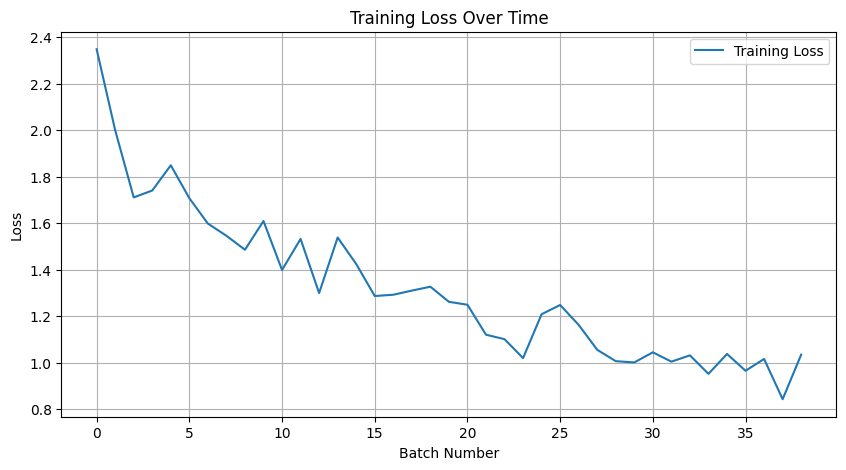

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_values, label="Training Loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Save fine-tuned model & tokenizer
model.save_pretrained("results/t5_finetuned")
tokenizer.save_pretrained("results/t5_finetuned")


('results/t5_finetuned/tokenizer_config.json',
 'results/t5_finetuned/special_tokens_map.json',
 'results/t5_finetuned/spiece.model',
 'results/t5_finetuned/added_tokens.json')